In [2]:
# [0]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysimul
import os
import csv

In [3]:
# [1]
def cma (X, k):
    M = np.zeros(len(X))
    for i in range(len(X)):
        a = max(0, i-k)
        b = min(len(X)-1, i+k)
        for j in range(a,b+1):
            M[i] += X[j]
        M[i] /= b-a+1
    return M

def plot_means_synth (t, X, cmak=4):
    plt.figure(figsize=(15,5))
    plt.plot(t, X, lw=1, color='royalblue')
    if cmak != 0:
        plt.plot(t, cma(X, cmak), color='navy')
    X_mean = np.mean(X)
    X_std = np.std(X)
    plt.axhline(X_mean, color='darkorange', label="Mean : {:.2e}".format(X_mean))
    plt.fill_between(t, X_mean-X_std, X_mean+X_std, facecolor='orange', alpha=0.3, label="Std. dev. : {:.1e}".format(X_std))
    (X_slope, X0) = np.polyfit(t, X, 1)
    plt.plot(t, X0 + X_slope*t, color='darkorange', lw=1, label="Change : {:.1e}".format(X_slope*(t[-1]-t[0])))
    plt.xlim([t[0],t[-1]])
    plt.legend()
    return (X_mean, X_std, X_slope)

def autocorrel (signal, sΔt, window):
    autoc = np.correlate(signal, signal, 'full')
    a,b = int(len(autoc)/2-window/sΔt), int(len(autoc)/2+window/sΔt)
    if a < 0:
        a = 0
        b = -1
        window = sΔt*len(autoc)/2
    autoc_win = autoc[a:b]
    tau = np.linspace(-window,+window,len(autoc_win))
    return tau, autoc_win

In [4]:
# [2]
simul = pysimul.PySimul()

In [5]:
# [3]
auto_mode = True
flag_end = False
rea_number = 32

In [4]:
auto_mode = False

In [296]:
# [5]
target_T = 1.5e2
simul["target_T"] = target_T

In [6]:
# [6]
def timer_f ():
    global simul, auto_mode, flag_end
    if simul is None:
        return 1
    simul.sfml_event_poll()
    if auto_mode and flag_end:
        flag_end = False
        return 2
    return 0

In [8]:
// [7]
%%javascript
var sfml_event_poll_timer = setInterval(function() {
    Jupyter.notebook.kernel.execute("print(timer_f())", { iopub : { output : function (data) {
        if (data.content.text == "1\n" || data.content.text === undefined)
            clearInterval(sfml_event_poll_timer);
        else if (data.content.text == "2\n") {
            Jupyter.notebook.execute_cells([16,17,18,19,20,21,13,14,22,11,8]);
        }
    }}})
}, 1000);

<IPython.core.display.Javascript object>

In [385]:
# [8]
simul.start()
sstart = 0
sstop = -1
has_beg = False
has_end = False
t_beg = 0.16
t_end = 0.38
def regular_callback (step, t):
    global has_beg, t_beg, t_end, flag_end, has_end, simul
    if t > t_beg and not has_beg:
        has_beg = True
        simul["target_T"] = -1
        simul["well_k"] = 0
        simul.reset_series("f_autocor_xx")
        simul.reset_series("f_autocor_xy")
        simul.reset_series("f_autocor_yy")
        simul.reset_series("vdist")
    if t > t_end and not has_end:
        flag_end = True
        has_end = True
        simul["pause"] = 1
simul.set_regular_callback(regular_callback)

In [10]:
simul["well_k"] = 0

In [2219]:
simul.end()
simul = None

In [384]:
# [11]
simul.end()
rea_number += 1

## Température

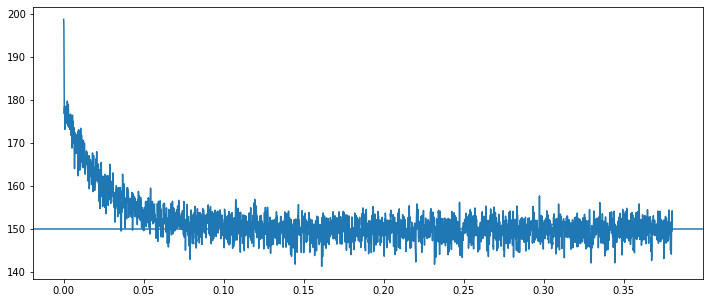

In [381]:
# [13]
simul.explicit_lock()
t = simul["sample_t"]
T = simul["Temp"]
simul.explicit_unlock()
plt.figure(figsize=(12,5))
plt.plot(t, T)
plt.axhline(y=target_T)

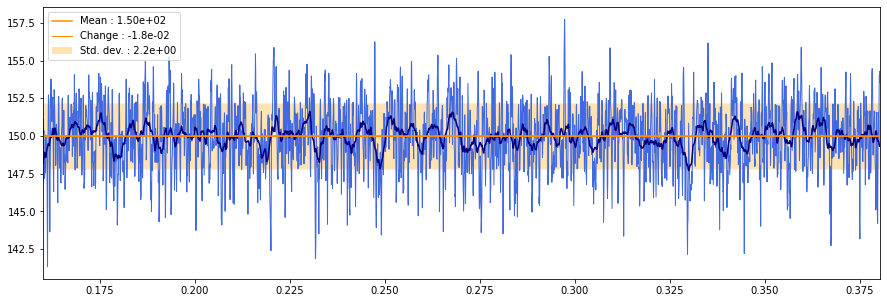

In [382]:
# [14]
(T_mean, T_std, T_slope) = plot_means_synth(t[sstart:sstop], T[sstart:sstop], cmak=20)
if auto_mode:
    plt.savefig(savepath+"/T_hist.png")

## Diffusion libre

In [375]:
# [16]
savepath = "/Users/xif/Desktop/Code/BrownianMotion/results_diffus_2/{:03d}".format(rea_number)
if not os.path.exists(savepath):
    os.mkdir(savepath)

2667 -1


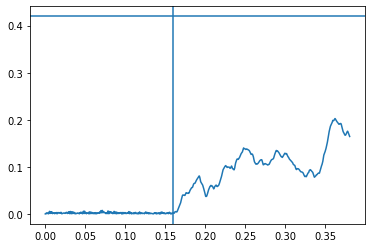

In [376]:
# [17]
simul.explicit_lock()
pt = simul["sample_t"]
px, py = simul["part_x"], simul["part_y"]
cont_r = simul["cont_r"]
part_d = simul["part_d"]
simul.explicit_unlock()

sstart = np.searchsorted(pt, t_beg, side='right')
pr = np.hypot(px-0.5, py-0.5)
sstop = np.argmax(pr > cont_r-part_d)
if sstop == 0:
    sstop = -1
print(sstart,sstop)

plt.plot(pt[:sstop], pr[:sstop])
plt.axhline(y=cont_r-part_d)
if sstart != len(pt):
    plt.axvline(x=pt[sstart])
if auto_mode:
    plt.savefig(savepath+"/p_r_hist.pdf")

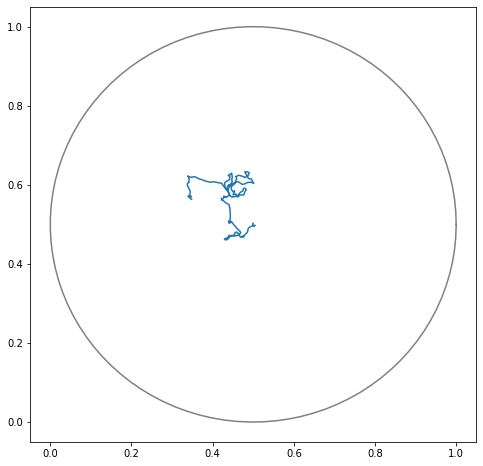

In [377]:
# [18]
plt.figure(figsize=(8,8))
plt.plot(px[sstart:sstop], py[sstart:sstop])
u = np.linspace(0,2*np.pi,100)
plt.plot((1+np.cos(u))/2,(1+np.sin(u))/2, color='grey')
if auto_mode:
    plt.savefig(savepath+"/p_traj.pdf")
    pd.DataFrame({
        't': pt[sstart:sstop],
        'px': px[sstart:sstop],
        'py': py[sstart:sstop]
    }).to_csv(savepath+"/p_traj.csv", index=False, float_format='%.8f')

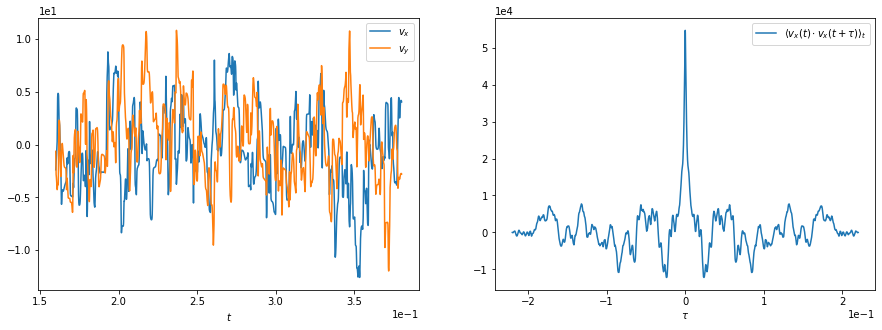

In [378]:
# [19]
simul.explicit_lock()
t = simul["sample_t"]
vx = simul["part_vx"]
vy = simul["part_vy"]
simul.explicit_unlock()
sΔt = np.mean(np.diff(t))

fix, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(t[sstart:sstop], vx[sstart:sstop], label="$v_x$")
ax1.plot(t[sstart:sstop], vy[sstart:sstop], label="$v_y$")
ax1.set_xlabel("$t$")
ax1.legend()
ax1.ticklabel_format(style='sci', scilimits=(0,0))

tau, v_autocor_xx = autocorrel(vx[sstart:sstop], sΔt, 1e0)
ax2.plot(tau, v_autocor_xx, label=r"$\langle v_x(t) \cdot v_x(t+\tau) \rangle_t$")
ax2.set_xlabel(r"$\tau$")
ax2.legend()
ax2.ticklabel_format(style='sci', scilimits=(0,0))

if auto_mode:
    plt.savefig(savepath+"/v.pdf")
    pd.DataFrame({
        'tau': tau,
        'c_vx_vx': v_autocor_xx,
    }).to_csv(savepath+"/c_vx_vx.csv", index=False, float_format='%.5e')

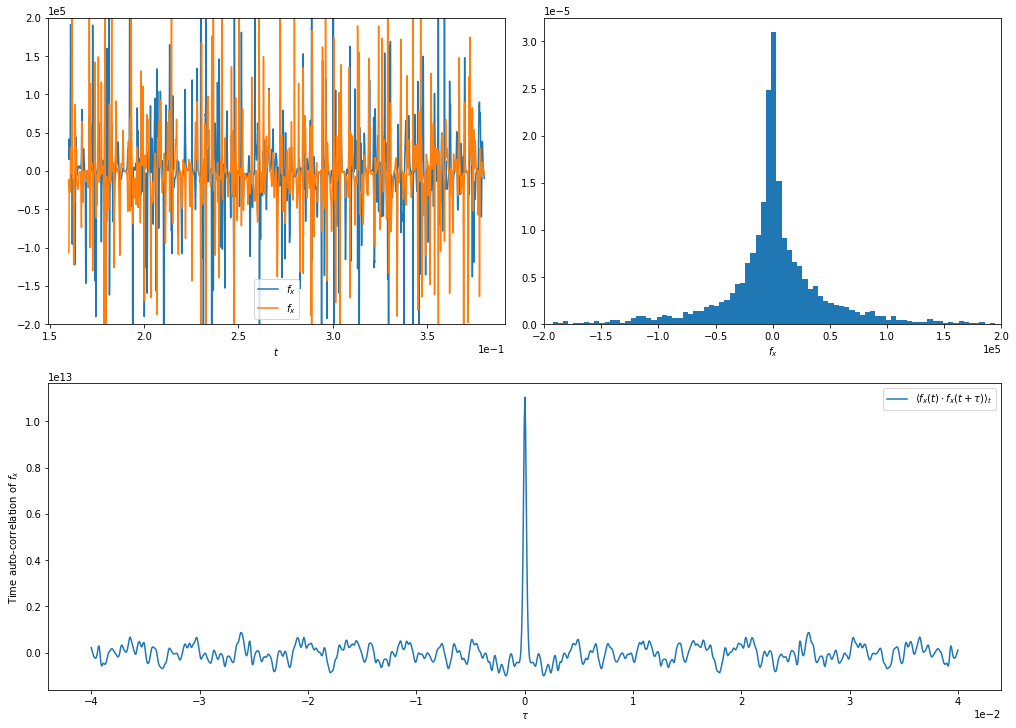

In [379]:
# [20]
simul.explicit_lock()
t = simul["sample_t"]
fx = simul["part_fx"]
fy = simul["part_fy"]
simul.explicit_unlock()
sΔt = np.mean(np.diff(t))

fig = plt.figure(constrained_layout=True, figsize=(14,10))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(t[sstart:sstop], fx[sstart:sstop], label='$f_x$')
ax1.plot(t[sstart:sstop], fy[sstart:sstop], label='$f_x$')
ax1.legend()
ax1.set_xlabel("$t$")
ax1.set_ylim((-2e5,+2e5))
ax1.ticklabel_format(style='sci', scilimits=(0,0))

ax2 = fig.add_subplot(gs[0,1])
ax2.hist(fx[sstart:sstop], bins=200, density=True)
ax2.set_xlabel("$f_x$")
ax2.set_xlim((-2e5,+2e5))
ax2.ticklabel_format(style='sci', scilimits=(0,0))

ax3 = fig.add_subplot(gs[1,:])
tau, f_autocor_xx = autocorrel(fx[sstart:sstop], sΔt, 4e-2)
ax3.plot(tau, f_autocor_xx, label=r"$\langle f_x(t) \cdot f_x(t+\tau) \rangle_t$")
ax3.legend()
ax3.set_xlabel(r"$\tau$")
ax3.set_ylabel(r"Time auto-correlation of $f_x$")
ax3.ticklabel_format(style='sci', scilimits=(0,0))

if auto_mode:
    plt.savefig(savepath+"/f.pdf")
    pd.DataFrame({
        'tau': tau,
        'c_fx_fx': f_autocor_xx,
    }).to_csv(savepath+"/c_fx_fx.csv", index=False, float_format='%.4e')

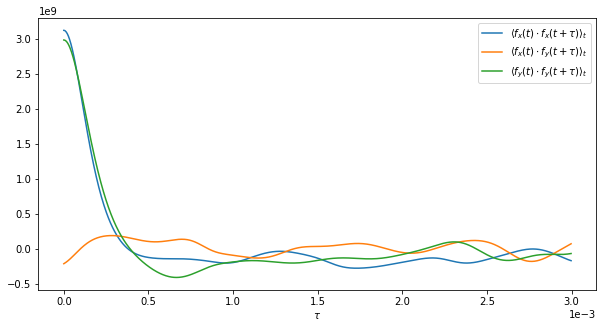

In [380]:
# [21]
plt.figure(figsize=(10,5))

Δt = simul["Delta_t"]

(acc, samples) = simul["f_autocor_xx"]
f_autocor_xx = acc / samples
tau = Δt*np.arange(0,len(f_autocor_xx),1)
plt.plot(tau, f_autocor_xx, label=r"$\langle f_x(t) \cdot f_x(t+\tau) \rangle_t$")

(acc, samples) = simul["f_autocor_xy"]
f_autocor_xy = acc / samples
plt.plot(tau, f_autocor_xy, label=r"$\langle f_x(t) \cdot f_y(t+\tau) \rangle_t$")

(acc, samples) = simul["f_autocor_yy"]
f_autocor_yy = acc / samples
plt.plot(tau, f_autocor_yy, label=r"$\langle f_y(t) \cdot f_y(t+\tau) \rangle_t$")

plt.legend()
plt.xlabel(r"$\tau$")
plt.ticklabel_format(style='sci', scilimits=(0,0))

if auto_mode:
    plt.savefig(savepath+"/f_autocorr.pdf")
    pd.DataFrame({
        'tau': tau,
        'c_fx_fx': f_autocor_xx,
        'c_fy_fy': f_autocor_yy,
        'c_fx_fy': f_autocor_xy,
    }).to_csv(savepath+"/c_f_f_fine.csv", index=False, float_format='%.4e')

In [383]:
# [22]
results = {}

results['T'] = T_mean
results['T_std'] = T_std

df = pd.DataFrame(list(results.items())).set_index(0)
_ = df.to_csv(savepath+"/res.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')

## Distribution des vitesses

In [8]:
simul.reset_series("vdist")

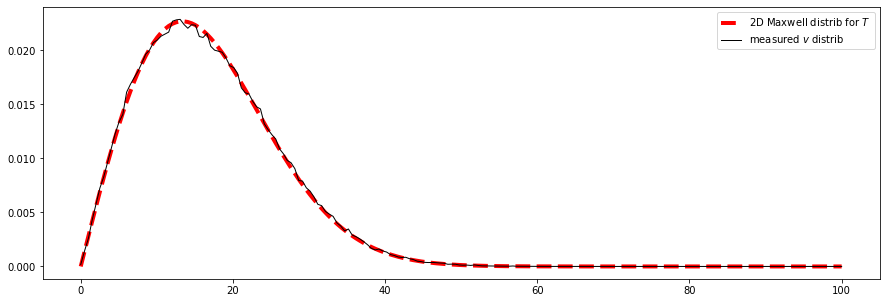

In [35]:
plt.figure(figsize=(15,5))
(acc, samples) = simul["vdist"]
v = np.linspace(0,1e2,len(acc))
d = acc/samples

m = 1
def maxwell_distr_2D (v, T):
    return (m/(2*T))* v * np.exp(-m * v**2 /(2*T))
plt.plot(v, maxwell_distr_2D(v, T_mean), '--', color='red', lw=4, label='2D Maxwell distrib for $T$')

plt.plot(v, d, lw=1, color='black', label='measured $v$ distrib')

plt.legend()
if auto_mode:
    plt.savefig(savepath+"/v_distr.pdf")